In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler,LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import StratifiedKFold


In [3]:
train_data = pd.read_csv("D:/Git/RepoMALEKWHAT/ML.-KAGGLE/Predict_human_psycotype/data/train.csv")
test_data = pd.read_csv("D:/Git/RepoMALEKWHAT/ML.-KAGGLE/Predict_human_psycotype/data/test.csv")
train_data = train_data.drop("id", axis=1)
test_data = test_data.drop("id", axis=1)

# EDA

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           17334 non-null  float64
 1   Stage_fear                 16631 non-null  object 
 2   Social_event_attendance    17344 non-null  float64
 3   Going_outside              17058 non-null  float64
 4   Drained_after_socializing  17375 non-null  object 
 5   Friends_circle_size        17470 non-null  float64
 6   Post_frequency             17260 non-null  float64
 7   Personality                18524 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.1+ MB


 **В данных есть много пропущенных значений**

In [5]:
train_data.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,3.137764,5.265106,4.044319,7.996737,4.982097
std,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,3.000000,5.000000,3.000000
50%,2.000000,5.000000,4.000000,8.000000,5.000000
75%,4.000000,8.000000,6.000000,12.000000,7.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


In [6]:
train_data.sample(5)

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
806,3.0,No,4.0,7.0,No,6.0,5.0,Extrovert
18097,0.0,No,9.0,4.0,No,11.0,5.0,Extrovert
11616,9.0,Yes,0.0,3.0,Yes,5.0,0.0,Introvert
13091,9.0,Yes,3.0,0.0,NaN,1.0,1.0,Introvert
13179,0.0,No,9.0,5.0,No,14.0,10.0,Extrovert


**Задача бинарной классификации, в данных также есть бинарные категориальные признаки**

In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           5750 non-null   float64
 1   Stage_fear                 5577 non-null   object 
 2   Social_event_attendance    5778 non-null   float64
 3   Going_outside              5709 non-null   float64
 4   Drained_after_socializing  5743 non-null   object 
 5   Friends_circle_size        5825 non-null   float64
 6   Post_frequency             5767 non-null   float64
dtypes: float64(5), object(2)
memory usage: 337.8+ KB


**В тестовых данных также есть пропуски**

**Посмотрим как устроенны данные до предобработки, для этого удалим все строки, где есть хотя бы один пропуск**

In [8]:
data_no_mis = train_data.dropna(axis=0, how='any')
data_no_mis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10189 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           10189 non-null  float64
 1   Stage_fear                 10189 non-null  object 
 2   Social_event_attendance    10189 non-null  float64
 3   Going_outside              10189 non-null  float64
 4   Drained_after_socializing  10189 non-null  object 
 5   Friends_circle_size        10189 non-null  float64
 6   Post_frequency             10189 non-null  float64
 7   Personality                10189 non-null  object 
dtypes: float64(5), object(3)
memory usage: 716.4+ KB


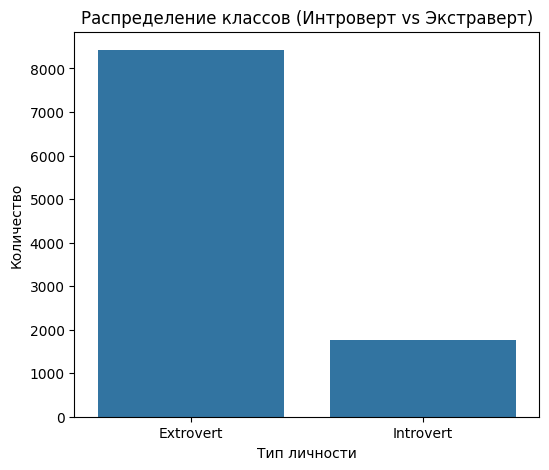

In [9]:
plt.figure(figsize=(6, 5))
sns.countplot(data=data_no_mis, x='Personality')
plt.title('Распределение классов (Интроверт vs Экстраверт)')
plt.xlabel('Тип личности')
plt.ylabel('Количество')
plt.show()

**Очень большой дизбаланс по классам, выборка не репрезентативна**

In [10]:
data_no_mis.columns

Index(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')

**Обучающая выборка сократилась почти вдвое, но мы больше доверяем этим данным и можем строить гипотезы основываясь на них**

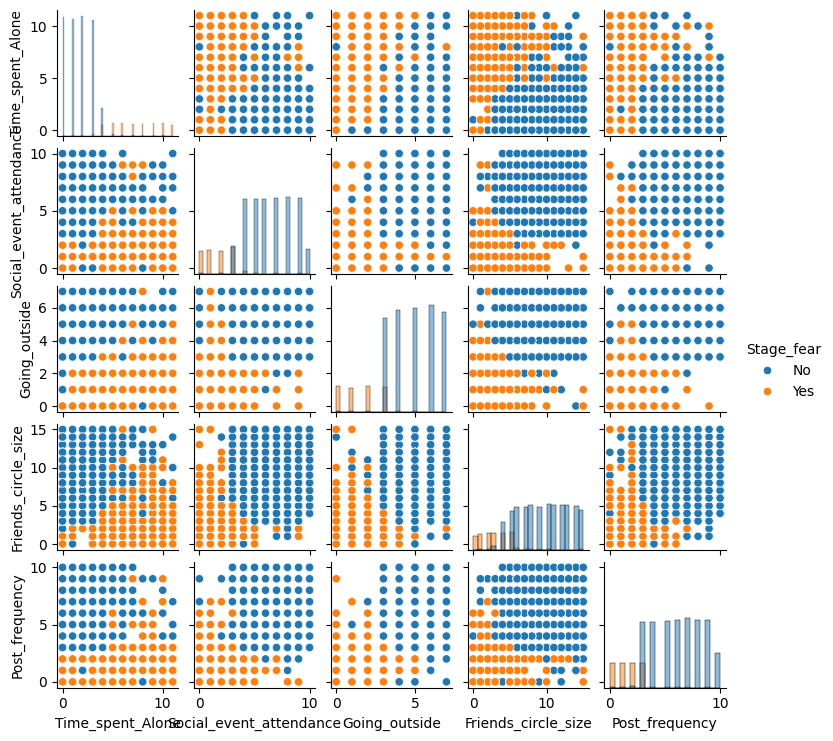

In [11]:
sns.pairplot(data_no_mis.iloc[:, [0, 1, 2, 3, 5, 6]], hue="Stage_fear", diag_kind='hist', height=1.5)

**Взаимосвязь имеется, но не такая сильная, классы часто пересекаются. Оно и понятно, далеко не каждый Экстроверт не боится выступать на сцене**

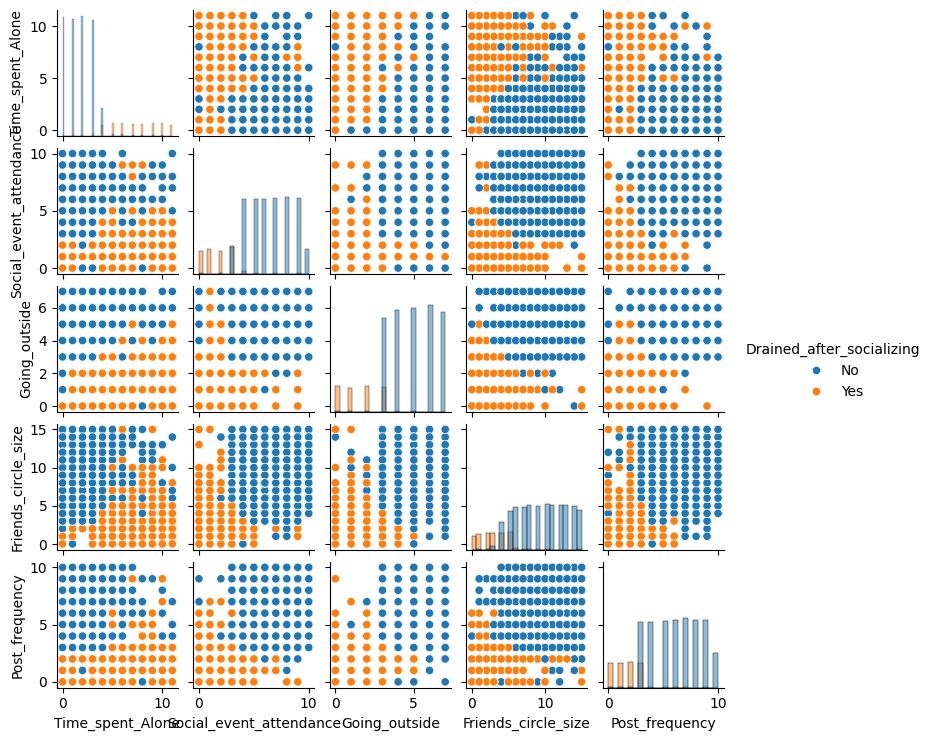

In [12]:
sns.pairplot(data_no_mis.iloc[:, [0, 2, 3, 4, 5, 6]], hue="Drained_after_socializing", diag_kind='hist', height=1.5)

**Тут кластеры уже более разделимы**

**И , наконец, таргет:**

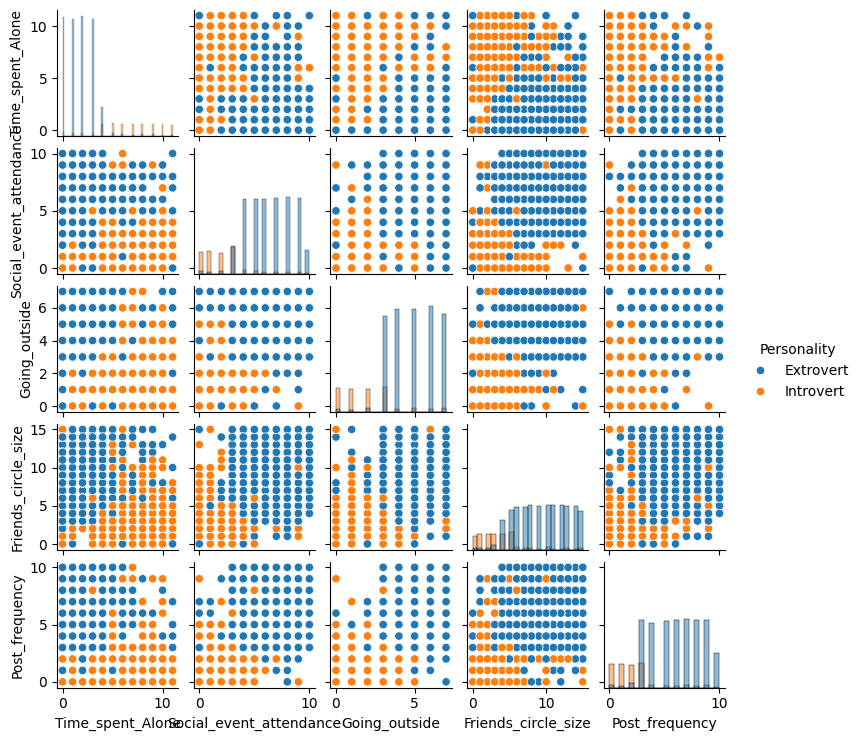

In [13]:
sns.pairplot(data_no_mis.iloc[:, [0, 2, 3, 5, 6, 7]], hue="Personality", diag_kind='hist', height=1.5)

**Кластеры визуально разделимы и это отлично, имеем хорошее признаковое описание задачи, хотя хорошее не значит лучшее и мы обязательно его расширим**

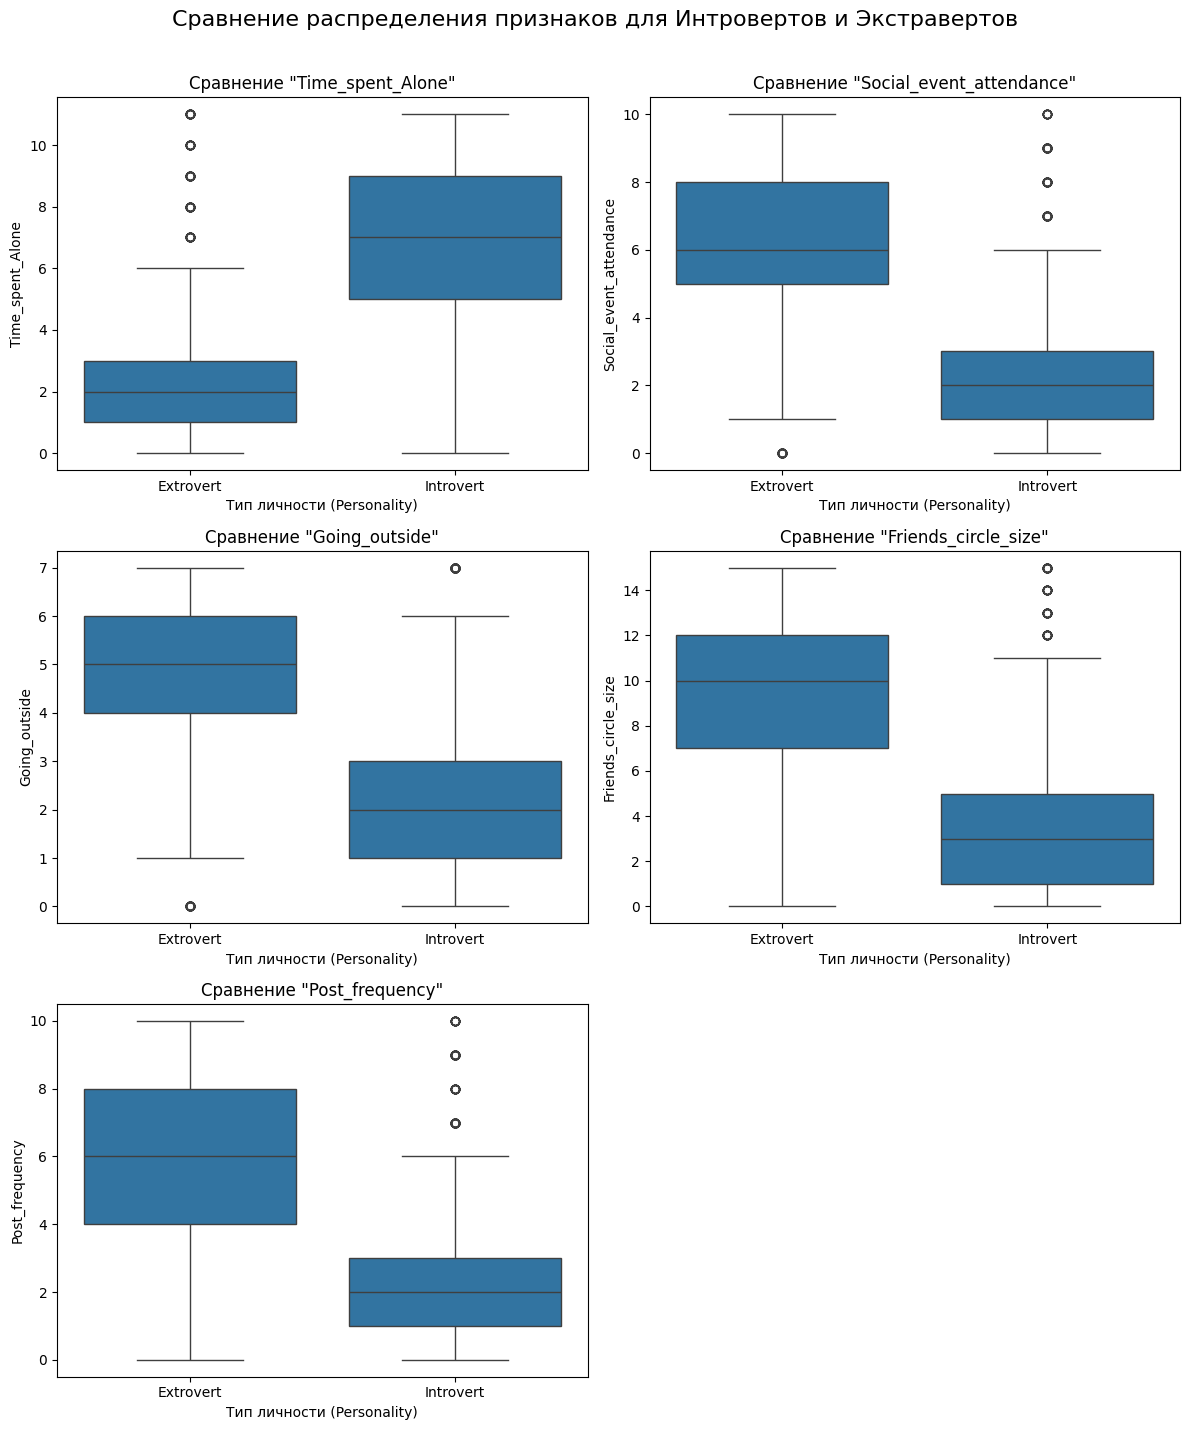

In [14]:
numerical_features = [
    'Time_spent_Alone',
    'Social_event_attendance',
    'Going_outside',
    'Friends_circle_size',
    'Post_frequency'
]

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(data=data_no_mis, x='Personality', y=feature, ax=axes[i])
    axes[i].set_title(f'Сравнение "{feature}"')
    axes[i].set_xlabel('Тип личности (Personality)')
    axes[i].set_ylabel(feature)

for j in range(len(numerical_features), len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Сравнение распределения признаков для Интровертов и Экстравертов', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

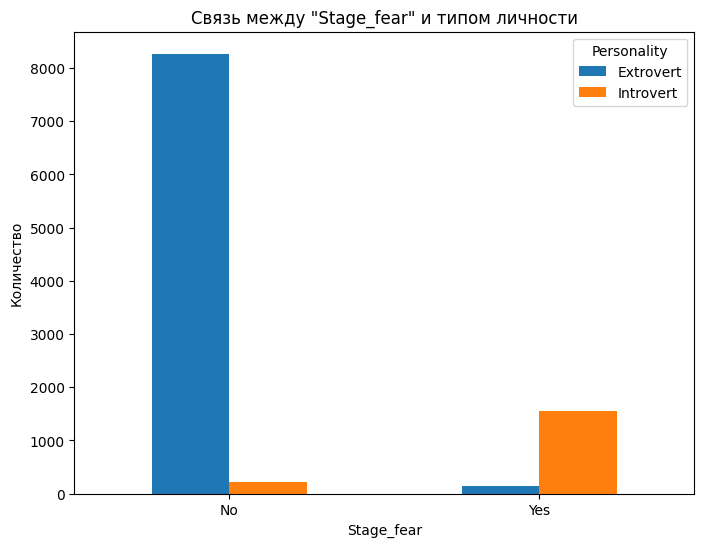

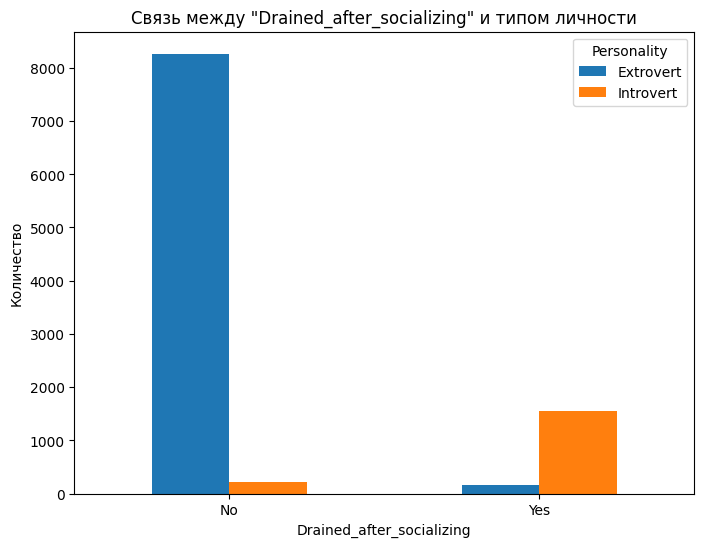

In [15]:
for feature in ['Stage_fear', 'Drained_after_socializing']:
    pd.crosstab(data_no_mis[feature], data_no_mis['Personality']).plot(kind='bar', figsize=(8,6))
    plt.title(f'Связь между "{feature}" и типом личности')
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.xticks(rotation=0)
    plt.show()

C:\Temp\ipykernel_3484\3270530974.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_mis[column] = labEn.fit_transform(data_no_mis[column])
C:\Temp\ipykernel_3484\3270530974.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_mis[column] = labEn.fit_transform(data_no_mis[column])
C:\Temp\ipykernel_3484\3270530974.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

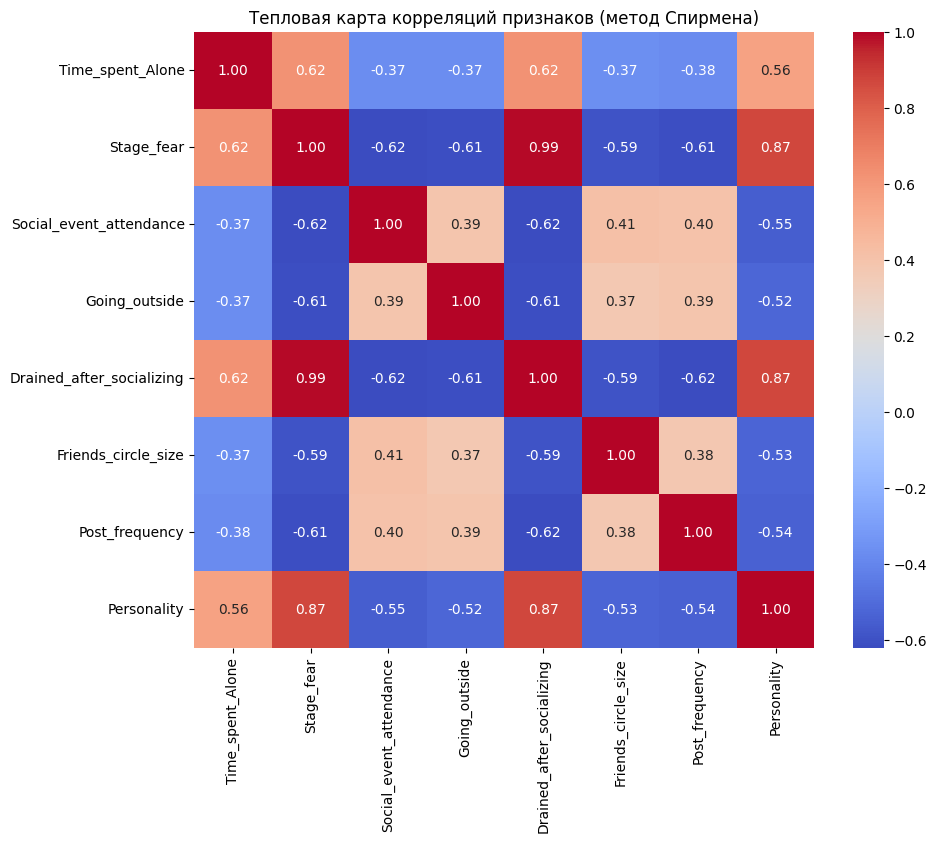

In [16]:
labEn = LabelEncoder()
for column in ['Personality', 'Stage_fear', 'Drained_after_socializing']:
    data_no_mis[column] = labEn.fit_transform(data_no_mis[column])


plt.figure(figsize=(10, 8))
sns.heatmap(data=data_no_mis.corr(method="spearman"), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Тепловая карта корреляций признаков (метод Спирмена)')
plt.show()

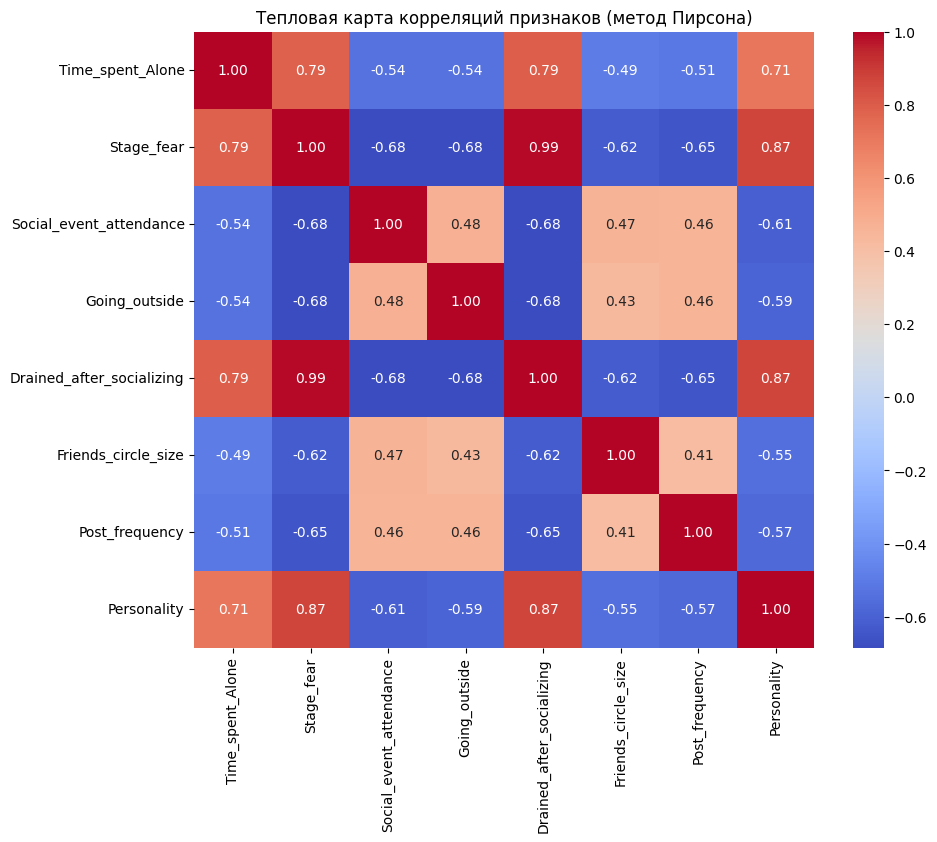

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(data=data_no_mis.corr(method="pearson"), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Тепловая карта корреляций признаков (метод Пирсона)')
plt.show()

**ОЧЕНЬ БОЛЬШИЕ КОРРЕЛЯЦИИ МЕЖДУ ПРИЗНАКАМИ**

# Обработка данных

**Выделим категориальные признаки и цисленные**

In [18]:
def sep_data(data):
    mask = (data.dtypes == "object").values
    dec_data = data[data.columns[~mask]]
    cat_data = data[data.columns[mask]]
    return (dec_data, cat_data)
dec_data_train, cat_data_train = sep_data(train_data)
dec_data_test, cat_data_test = sep_data(test_data)

In [19]:
cat_data_train.sample(3)

,Stage_fear,Drained_after_socializing,Personality
7012,NaN,NaN,Extrovert
2352,No,No,Extrovert
10274,No,No,Extrovert


**Идея: заполнить пропуски с помощью метрического метода регрессии - kNN. То есть заполняем пропуски близкими значениями из выборки, а не средним/медианой. Для хорошей работы метрических методов необходимо сделать Стандартезацию, то есть отмасштабировать признаки. Также выделенные раннее категориальные признаки необходимо закодировать, признаки с помощью OrdinalEncoder, таргет с помощью LabelEncoder. Таким образом, пайплайн действий:**
## Численные признаки:
- **StandartScaler**
- **kNN Imputer**
## Категориальные признаки:
- **LabelEncoder**
- **OrdinalEncoder**
- **kNN Imputer**

In [20]:
std = StandardScaler()
kNN = KNNImputer(n_neighbors=5)
labelEncoder = LabelEncoder()
OrdEncoder = OrdinalEncoder()

cat_data_train, target = cat_data_train.drop("Personality", axis=1), cat_data_train["Personality"]
target = pd.DataFrame(data=labelEncoder.fit_transform(target))



def knn_data_proc(train_data, test_data):
    norm_train = std.fit_transform(train_data)
    norm_test = std.transform(test_data)

    norm_train = pd.DataFrame(data=norm_train,
                              columns=train_data.columns)
    norm_test = pd.DataFrame(data=norm_test,
                              columns=test_data.columns)

    clean_data_train = pd.DataFrame(data = kNN.fit_transform(norm_train),
                              columns=train_data.columns)
    clean_data_test = pd.DataFrame(data = kNN.transform(norm_test),
                              columns=test_data.columns)
    return (clean_data_train, clean_data_test)

def coder(train, test):
    clean_cat_train_data = pd.DataFrame(data=OrdEncoder.fit_transform(train),
                              columns=train.columns)
    clean_cat_test_data = pd.DataFrame(data=OrdEncoder.transform(test),
                              columns=test.columns)
    return (clean_cat_train_data, clean_cat_test_data)


clean_dec_train_data,clean_dec_test_data  = knn_data_proc(dec_data_train, dec_data_test)

clean_cat_train_data, clean_cat_test_data = coder(cat_data_train, cat_data_test)


In [21]:
combine_train_data = pd.concat([clean_dec_train_data, clean_cat_train_data],axis=1)
combine_test_data = pd.concat([clean_dec_test_data, clean_cat_test_data], axis=1)

In [22]:
final_train = pd.DataFrame(data = kNN.fit_transform(combine_train_data),
                          columns=combine_train_data.columns)
final_test = pd.DataFrame(data = kNN.transform(combine_test_data),
                          columns=combine_test_data.columns)

In [23]:
final_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           18524 non-null  float64
 1   Social_event_attendance    18524 non-null  float64
 2   Going_outside              18524 non-null  float64
 3   Friends_circle_size        18524 non-null  float64
 4   Post_frequency             18524 non-null  float64
 5   Stage_fear                 18524 non-null  float64
 6   Drained_after_socializing  18524 non-null  float64
dtypes: float64(7)
memory usage: 1013.2 KB


In [24]:
final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           6175 non-null   float64
 1   Social_event_attendance    6175 non-null   float64
 2   Going_outside              6175 non-null   float64
 3   Friends_circle_size        6175 non-null   float64
 4   Post_frequency             6175 non-null   float64
 5   Stage_fear                 6175 non-null   float64
 6   Drained_after_socializing  6175 non-null   float64
dtypes: float64(7)
memory usage: 337.8 KB


In [25]:
final_train.sample(3)

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency,Stage_fear,Drained_after_socializing
7438,-0.045865,-0.459491,0.172450,1.421441,0.700890,0.0,0.0
16712,0.619981,-1.912303,-0.991176,-0.946340,-1.383126,1.0,1.0
5156,-0.711710,0.266916,0.948200,1.421441,-0.341118,0.0,0.0


# FAETURE ENGINEERING

In [26]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Добавляет комплексные признаки для улучшения прогноза.
    """
    df = df.copy()

    
    df['Social_score'] = df['Social_event_attendance'] + df['Going_outside'] + df['Friends_circle_size']
    
    epsilon = 1e-6
    df['Social_vs_Alone'] = df['Social_score'] / (df['Time_spent_Alone'] + epsilon)
    
    df['Event_Density'] = df['Social_event_attendance'] / (df['Going_outside'] + epsilon)
    
    df['Online_vs_Offline'] = df['Post_frequency'] / (df['Social_score'] + epsilon)
    
    df['Friends_circle_size_sq'] = df['Friends_circle_size']**2
    df['Time_spent_Alone_sq'] = df['Time_spent_Alone']**2

    df['Introvert_Fatigue_Score'] = df['Time_spent_Alone'] * df['Drained_after_socializing']
    
    df['Social_Anxiety_Interaction'] = df['Social_score'] * df['Stage_fear']

    return df

final_train = add_features(final_train)
final_test = add_features(final_test)

print(final_train.columns)

Index(['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
       'Friends_circle_size', 'Post_frequency', 'Stage_fear',
       'Drained_after_socializing', 'Social_score', 'Social_vs_Alone',
       'Event_Density', 'Online_vs_Offline', 'Friends_circle_size_sq',
       'Time_spent_Alone_sq', 'Introvert_Fatigue_Score',
       'Social_Anxiety_Interaction'],
      dtype='object')


# ПОДБОР МОДЕЛЕЙ И ГИПЕРПАРАМЕТРОВ

In [27]:
X_train, X_test, y_train, y_test = train_test_split(final_train, target, test_size=0.25)

In [62]:
import warnings
warnings.filterwarnings('ignore')

model = LogisticRegression(random_state=42, max_iter=5000)
param_grid = [
    {
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'C': [0.001, 0.01, 0.08, 0.1, 0.3, 0.7, 1],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': ['l2'],
        'solver': ['lbfgs', 'newton-cg', 'sag', 'saga', 'liblinear'],
        'C': [0.001, 0.01, 0.08, 0.1, 0.3, 0.7, 1],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'C': [0.001, 0.01, 0.08, 0.1, 0.3, 0.7, 1],
        'class_weight': [None, 'balanced'],
        'l1_ratio': [0.25, 0.5, 0.75]
    }
]

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train.values.ravel())

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая метрика на кросс-валидации: {grid_search.best_score_:.3f}")

test_accuracy = grid_search.score(X_test, y_test)
print(f"Accuracy на тестовой выборке: {test_accuracy:.3f}")

#best_model = grid_search.best_estimator_
#predictions = best_model.predict(new_data)

Fitting 3 folds for each of 140 candidates, totalling 420 fits
Лучшие параметры: {'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
Лучшая метрика на кросс-валидации: 0.968
Accuracy на тестовой выборке: 0.973


In [30]:
model2 = lgb.LGBMClassifier(random_state=42)

param_grid2 = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [10, 20, 25],
    'max_depth': [-1, 5, 10, 15],
    'reg_alpha': [0.02, 0.05, 0.07],
    'reg_lambda': [0.05, 0.1, 0.2]
}

grid_search2 = GridSearchCV(
    estimator=model2,
    param_grid=param_grid2,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search2.fit(X_train, y_train.values.ravel())

print(f"Лучшие параметры: {grid_search2.best_params_}")
print(f"Лучшая метрика на кросс-валидации: {grid_search2.best_score_:.3f}")

test_accuracy = grid_search2.score(X_test, y_test)
print(f"Accuracy на тестовой выборке: {test_accuracy:.3f}")

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
[LightGBM] [Info] Number of positive: 3640, number of negative: 10253
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1669
[LightGBM] [Info] Number of data points in the train set: 13893, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.262002 -> initscore=-1.035587
[LightGBM] [Info] Start training from score -1.035587
Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 20, 'reg_alpha': 0.05, 'reg_lambda': 0.1}
Лучшая метрика на кросс-валидации: 0.969
Accuracy на тестовой выборке: 0.969


In [34]:
best_model = grid_search2.best_estimator_ 
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
predictions = []

for fold, (train_idx, val_idx) in enumerate(skf.split(final_train, target)):
    X_train_fold, y_train_fold = final_train.iloc[train_idx], target.iloc[train_idx]
    best_model.fit(X_train_fold, y_train_fold.values.ravel())
    
    #делаем предсказание на ВСЕЙ тестовой выборке
    #предсказываем вероятности, а не классы
    fold_preds = best_model.predict_proba(final_test)[:, 1] 
    predictions.append(fold_preds)

#axis=0 - усреднение по фолдам
final_predictions_proba = np.mean(predictions, axis=0)
final_predictions_labels = (final_predictions_proba > 0.5).astype(int)

sub = pd.read_csv("D:/Git/RepoMALEKWHAT/ML.-KAGGLE/Predict_human_psycotype/data/sample_submission.csv")
sub["Personality"] = final_predictions_labels
sub['Personality'] = sub['Personality'].map({
    0: 'Extrovert',
    1: 'Introvert'
})
sub.to_csv("D:/Git/RepoMALEKWHAT/ML.-KAGGLE/Predict_human_psycotype/data/answerLGBm.csv", index=False)

[LightGBM] [Info] Number of positive: 4342, number of negative: 12329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1691
[LightGBM] [Info] Number of data points in the train set: 16671, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260452 -> initscore=-1.043619
[LightGBM] [Info] Start training from score -1.043619
[LightGBM] [Info] Number of positive: 4342, number of negative: 12329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1691
[LightGBM] [Info] Number of data points in the train set: 16671, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260452 -> initscore=-1.043619
[LightGBM] [Info] Start training from score -1.043619
[LightGBM] [In

In [ ]:
logreg = LogisticRegression(C=0.1, class_weight=None, l1_ratio=0.25, penalty='l1', solver='saga',max_iter=1000)
logreg.fit(final_train, target.to_numpy().ravel())
sub = pd.read_csv("D:\Git\RepoMALEKWHAT\ML.-KAGGLE\Predict_human_psycotype\data\sample_submission.csv")
sub["Personality"] = logreg.predict(final_test)
sub['Personality'] = sub['Personality'].map({
    0: 'Extrovert',
    1: 'Introvert'
})
sub.to_csv("D:/Git/RepoMALEKWHAT/ML.-KAGGLE/Predict_human_psycotype/data/answerLGBM.csv", index=False)